In [1]:
import torch
import numpy as np  
from matplotlib import pyplot as plt    
import torchvision
from torchvision import transforms  
from torch.utils.data import DataLoader

# Hàm lấy dữ liệu
* input: batchsize
* output: dữ liệu tập train và test


In [2]:
def load_data_fashion_mnist(batch_size=32):
    trans = transforms.ToTensor()
    mnist_train = torchvision.datasets.FashionMNIST(root='FashionMNIST/raw/train-images-idx3-ubyte', train=True, download=False, transform=trans)
    mnist_test = torchvision.datasets.FashionMNIST(root='FashionMNIST/raw/t10k-images-idx3-ubyte', train=False, download=False, transform=trans)

    return (DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, num_workers=4),
            DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, num_workers=4))


In [3]:
batch_size = 32
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

# Khởi tạo tham số
Trải ảnh 28x28 thành một vector 784 điểm => ma trận trọng số là 784x10, vector bias là 10 cột <br>
Khởi tạo ma trận trọng số theo phân phối chuẩn Gauss, bias là toàn 0

In [140]:
# init params
num_inputs = 784
num_outputs = 10

W = torch.normal(mean=0, std=0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.ones(num_outputs, requires_grad=True)

# Hàm softmax
* input: X là một ma trận, Tensor
* output: Tensor chứa giá trị của các phần tử qua hàm softmax

In [38]:
def softmax(X):
    exp_z = torch.exp(X)
    partition = exp_z.sum(dim=1, keepdim=True)

    return exp_z/partition

# Định nghĩa mô hình

In [39]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, num_inputs), W) + b)

# Hàm mất mát
Ở đây sử dụng cross entropy để tính toán 
dùng cú pháp pickle để hạn chế thời gian của vòng lặp

In [7]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

# Hàm tính toán độ chính xác của mô hình
Là bằng tổng số dự đoán chính xác / tổng mẫu cần tính toán

In [86]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.2, 0.3, 0.5]])
y = torch.tensor([0, 2])

In [98]:
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [83]:
(y_hat.argmax(dim=1) == y).float().mean().item()

1.0

In [84]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [89]:
accuracy(y_hat, y)

0.5

In [90]:
def evaluate_accuracy(net, data_iter):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).sum().item()
        n += y.size()[0]
    
    return acc_sum / n

In [96]:
evaluate_accuracy(net, test_iter)

0.1351

# Thuật toán tối ưu
Sử dụng stochastic gradient descent để tối ưu <br>
* input: learning rate, batch size

In [97]:
def sgd(params, lr=0.01, batch_size=32):
    for param in params:
        param.data = param.data - lr*param.grad/batch_size
        param.grad.zero_()

In [144]:
def train(train_iter, test_iter, net, loss, num_epochs, lr, batch_size):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for epoch in range(num_epochs):
        for X, y in train_iter:
            y_hat = net(X)

            l = loss(y_hat, y).sum()
            l.backward()

            sgd([W, b], lr=lr, batch_size=batch_size)

            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.size()[0]
        
        test_acc = evaluate_accuracy(net, test_iter)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))


In [145]:
train(train_iter, test_iter, net, loss=cross_entropy, num_epochs=50, lr=0.01, batch_size=16)

epoch 1, loss 0.4263, train acc 0.854, test acc 0.838
epoch 2, loss 0.4247, train acc 0.855, test acc 0.836
epoch 3, loss 0.4233, train acc 0.855, test acc 0.837
epoch 4, loss 0.4219, train acc 0.856, test acc 0.844
epoch 5, loss 0.4207, train acc 0.856, test acc 0.840
epoch 6, loss 0.4195, train acc 0.857, test acc 0.842
epoch 7, loss 0.4184, train acc 0.857, test acc 0.845
epoch 8, loss 0.4174, train acc 0.857, test acc 0.841
epoch 9, loss 0.4164, train acc 0.858, test acc 0.840
epoch 10, loss 0.4155, train acc 0.858, test acc 0.843
epoch 11, loss 0.4146, train acc 0.858, test acc 0.844
epoch 12, loss 0.4137, train acc 0.858, test acc 0.843
epoch 13, loss 0.4129, train acc 0.859, test acc 0.843
epoch 14, loss 0.4121, train acc 0.859, test acc 0.839
epoch 15, loss 0.4114, train acc 0.859, test acc 0.844
epoch 16, loss 0.4107, train acc 0.859, test acc 0.842
epoch 17, loss 0.4101, train acc 0.860, test acc 0.842
epoch 18, loss 0.4094, train acc 0.860, test acc 0.845
epoch 19, loss 0.40

In [49]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [132]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols*scale, num_rows*scale)
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols)
    # flat axet to 1D in order to iter easier
    axes = axes.flatten()

    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.reshape(28, 28).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        if titles:
            ax.set_title(titles[i], pad=10, fontsize=8)

        ax.set_anchor('W')
    
    plt.savefig("image.png",bbox_inches='tight',dpi=100)
    return axes


In [105]:
for X, y in test_iter:
    break

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]


array([<Axes: title={'center': 'ankle boot\nankle boot'}>,
       <Axes: title={'center': 'pullover\npullover'}>,
       <Axes: title={'center': 'trouser\ntrouser'}>,
       <Axes: title={'center': 'trouser\ntrouser'}>,
       <Axes: title={'center': 'shirt\nshirt'}>,
       <Axes: title={'center': 'trouser\ntrouser'}>,
       <Axes: title={'center': 'coat\ncoat'}>,
       <Axes: title={'center': 'shirt\nshirt'}>,
       <Axes: title={'center': 'sandal\nsandal'}>,
       <Axes: title={'center': 'sneaker\nsneaker'}>,
       <Axes: title={'center': 'coat\ncoat'}>,
       <Axes: title={'center': 'sandal\nsandal'}>,
       <Axes: title={'center': 'sneaker\nsandal'}>,
       <Axes: title={'center': 'dress\ndress'}>,
       <Axes: title={'center': 'coat\ncoat'}>,
       <Axes: title={'center': 'trouser\ntrouser'}>,
       <Axes: title={'center': 'pullover\npullover'}>,
       <Axes: title={'center': 'coat\npullover'}>,
       <Axes: title={'center': 'bag\nbag'}>,
       <Axes: title={'center

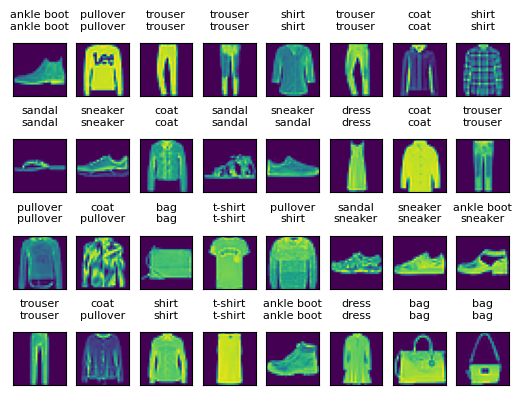

In [146]:
show_images(X[:], num_rows=4, num_cols=8, titles=titles, scale=1.5)